# Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

path = 'Colab Notebooks/NLP/Progetti/Covid19FakeNews'

os.chdir(f'/content/drive/MyDrive/{path}')
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/NLP/Progetti/Covid19FakeNews'

In [3]:
%%capture
!pip install clean-text


from cleantext import clean
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns


import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score




import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
pd.set_option('display.max_colwidth', 150)


# Data Loading


In [4]:
train_dataset=pd.read_csv("Constraint_Train.csv")
validation_dataset=pd.read_csv("Constraint_Val.csv")
test_dataset=pd.read_csv("english_test_with_labels.csv")

In [5]:
train_dataset.columns, test_dataset.columns, validation_dataset.columns

(Index(['id', 'tweet', 'label'], dtype='object'),
 Index(['id', 'tweet', 'label'], dtype='object'),
 Index(['id', 'tweet', 'label'], dtype='object'))

# Data Exploration


In [6]:
train_dataset.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death...,real
1,2,States reported 1121 deaths a small rise from last Tuesday. Southern states reported 640 of those deaths. https://t.co/YASGRTT4ux,real
2,3,Politically Correct Woman (Almost) Uses Pandemic as Excuse Not to Reuse Plastic Bag https://t.co/thF8GuNFPe #coronavirus #nashville,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testing laboratories in India and as on 25th August 2020 36827520 tests have been done : @ProfBhargava DG ...,real
4,5,Populous states can generate large case counts but if you look at the new cases per million today 9 smaller states are showing more cases per mill...,real


In [7]:
n_positiv=sum(train_dataset['label']=="real")
n_negative=sum(train_dataset['label']=="fake")
print(f"Number of positive samples: {n_positiv}")
print(f"Number of negative samples: {n_negative}")

Number of positive samples: 3360
Number of negative samples: 3060


In [8]:
positive10=train_dataset[train_dataset['label']=="real"]["tweet"][:10]
positive10

,tweet
0,The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death...
1,States reported 1121 deaths a small rise from last Tuesday. Southern states reported 640 of those deaths. https://t.co/YASGRTT4ux
3,#IndiaFightsCorona: We have 1524 #COVID testing laboratories in India and as on 25th August 2020 36827520 tests have been done : @ProfBhargava DG ...
4,Populous states can generate large case counts but if you look at the new cases per million today 9 smaller states are showing more cases per mill...
5,"Covid Act Now found ""on average each person in Illinois with COVID-19 is infecting 1.11 other people. Data shows that the infection growth rate ha..."
6,If you tested positive for #COVID19 and have no symptoms stay home and away from other people. Learn more about CDC’s recommendations about when y...
10,Take simple daily precautions to help prevent the spread of respiratory illnesses like #COVID19. Learn how to protect yourself from coronavirus (C...
12,We just announced that the first participants in each age cohort have been dosed in the Phase 2 study of our mRNA vaccine (mRNA-1273) against nove...
13,#CoronaVirusUpdates #IndiaFightsCorona More than 6 lakh tests done for 3rd successive day. Cumulative testing as on date has reached 22149351. #CO...
14,Protect yourself and others from #COVID19 when using public transportation. Practice social distancing avoid touching surfaces and practice hand h...


In [9]:
negative10=train_dataset[train_dataset['label']=="fake"]["tweet"][:10]
negative10

,tweet
2,Politically Correct Woman (Almost) Uses Pandemic as Excuse Not to Reuse Plastic Bag https://t.co/thF8GuNFPe #coronavirus #nashville
7,Obama Calls Trump’s Coronavirus Response A Chaotic Disaster https://t.co/DeDqZEhAsB
8,"???Clearly, the Obama administration did not leave any kind of game plan for something like this.??�"
9,Retraction—Hydroxychloroquine or chloroquine with or without a macrolide for treatment of COVID-19: a multinational registry analysis - The Lancet...
11,The NBA is poised to restart this month. In March we reported on how the Utah Jazz got 58 coronavirus tests in a matter of hours at a time when U....
16,"Because of Donald Trump's negligence and incompetence:\n \n- More than 110,000 people have died\n- We have nearly 2 million cases of COVID-19\n- O..."
19,Multiple Facebook posts claim that “Aussies will be fined if they are found to be talking about conspiracies to do with [COVID-19]”. The posts inc...
20,"No Nobel Prize laureate Tasuku Honjo didn't say the coronavirus is ""not natural"" as a post on Facebook claims. In fact Professor Honjo said he's ""..."
22,BREAKING NEWS# The president Cryill Ramaphosa has asked all foreign nations to depart south Africa before 21 june 2020 due to increasing cases of ...
25,Elon Musck To New Baby; Get A Job Kid! https://t.co/bc8Re0Ai3Y #christmas #covid19 #elonmusk #achristmascarol


In [10]:
corpus=[]
new= train_dataset["tweet"].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]
stop=nltk.corpus.stopwords.words('english')

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

<Axes: >

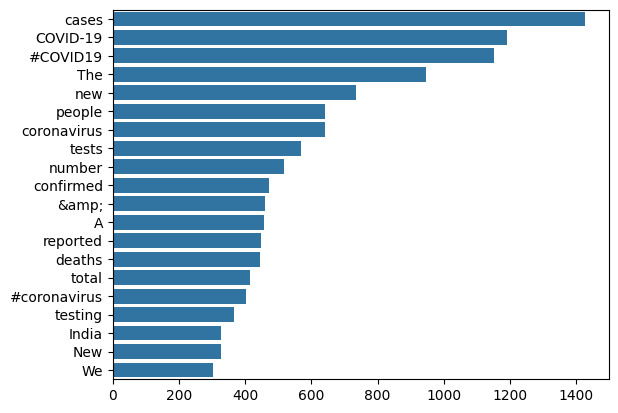

In [11]:
counter=Counter(corpus)
most=counter.most_common()

x, y= [], []
for word,count in most[:60]:
    if (word not in stop):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

# Data Preparation

In [12]:
sp="His home looks like an old abandoned military hut with very old brick walls. The living room was too small so brought out the tea tray for the reporters. All the cups are different. He met them with disheveled hair and casual clothes but with the confident smile of a Prime Minister #IndianArmy tribute to #CoronaWarriorsIndia #CoronaUpdatesInIndia #salutecoronawarriors on 3 may, 2020 🙏👏👏👏 @IndINDIANARMY @narendramodi https://t.co/BGNgJn2Uzu_ A video clip shows a doctor couple who died after treating 134 COVID-19 patients."

In [13]:
def personalized_substitution(tweet):
  #trump variations
  trump_variants = {"trumps", "realdonaldtrump", "donaltrump", "trump","donaldtrump"}
  pattern = r"\b(" + "|".join(trump_variants) + r")\b"

  regex = re.compile(pattern, re.IGNORECASE)

  tweet = regex.sub("trump", tweet)




  return tweet

In [14]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def cleanDataset(tweet):
  cleaned=clean(tweet,
    lower=True,
    no_emoji=True,
    replace_with_url="<URL>",
    no_urls=True,
    no_emails=True,
    no_phone_numbers=True,
    no_punct=True)

  cleaned=personalized_substitution(tweet)



  tokens = cleaned.split()
  without_stop = [w for w in tokens if w not in stop_words]

  stemmed_tokens = []
  for token in without_stop:
      if token.startswith("<") and token.endswith(">"):
          stemmed_tokens.append(token)
      else:
          stemmed_tokens.append(stemmer.stem(token))

  return " ".join(stemmed_tokens)



In [15]:
train_dataset["cleaned_tweet"]=train_dataset["tweet"].apply(cleanDataset)
validation_dataset["cleaned_tweet"]=validation_dataset["tweet"].apply(cleanDataset)
test_dataset["cleaned_tweet"]=test_dataset["tweet"].apply(cleanDataset)

# for index, row in train_dataset.iterrows():
#     print(row["cleaned_tweet"])

In [16]:
train_x=train_dataset["cleaned_tweet"]
train_y=train_dataset["label"]=="real"

validation_x=validation_dataset["cleaned_tweet"]
validation_y=validation_dataset["label"]=="real"

test_x=test_dataset["cleaned_tweet"]
test_y=test_dataset["label"]=="real"

In [17]:
# vectorizer.get_feature_names_out()[:1000]

In [18]:
count_vectorizer = CountVectorizer(max_features=5000,min_df=5, stop_words='english')
count_vectorizer.fit(train_x)
print(f"Vocabulary size: {len(count_vectorizer.get_feature_names_out())}")

train_x_vector_counted = count_vectorizer.transform(train_x)
validation_x_vector_counted = count_vectorizer.transform(validation_x)

train_x_vector_counted

Vocabulary size: 2581


<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 84206 stored elements and shape (6420, 2581)>

In [19]:
tfIdf_vectorizer = TfidfVectorizer(max_features=5000,min_df=5, stop_words='english')
tfIdf_vectorizer.fit(train_x)
print(f"Vocabulary size: {len(tfIdf_vectorizer.get_feature_names_out())}")

train_x_vector_tfIdf = tfIdf_vectorizer.transform(train_x)
validation_x_vector_tfIdf = tfIdf_vectorizer.transform(validation_x)

train_x_vector_tfIdf

Vocabulary size: 2581


<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 84206 stored elements and shape (6420, 2581)>

In [20]:
i = random.randrange(len(train_x))

print('Random tweet:')
print(train_x[i])

print('\nSparse vector:')
print(train_x_vector_counted[i])
print(train_x_vector_tfIdf[i])

vocab = count_vectorizer.get_feature_names_out()
print('\nVocabulary of tweet:')
[(j,vocab[j]) for j in train_x_vector_counted[i].nonzero()[1]]

Random tweet:
cdc offer technic assist &amp; resourc help inform state &amp; local school system work health offici make community-bas decis open k-12 school #covid19 pandemic. https://t.co/cqjow6vrmf https://t.co/clk837dk89

Sparse vector:
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 23 stored elements and shape (1, 2581)>
  Coords	Values
  (0, 24)	1
  (0, 275)	2
  (0, 328)	1
  (0, 366)	1
  (0, 495)	1
  (0, 589)	1
  (0, 669)	1
  (0, 732)	1
  (0, 1146)	1
  (0, 1156)	1
  (0, 1201)	2
  (0, 1268)	1
  (0, 1425)	1
  (0, 1457)	1
  (0, 1647)	1
  (0, 1649)	1
  (0, 1666)	1
  (0, 1701)	1
  (0, 1990)	1
  (0, 2067)	2
  (0, 2208)	1
  (0, 2311)	1
  (0, 2544)	1
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 23 stored elements and shape (1, 2581)>
  Coords	Values
  (0, 24)	0.17896466229531205
  (0, 275)	0.2690835206904412
  (0, 328)	0.24567736681162994
  (0, 366)	0.24567736681162994
  (0, 495)	0.16044730559785084
  (0, 589)	0.21718571831113204
  (0, 669)	0.086959221113583

[(np.int32(24), '12'),
 (np.int32(275), 'amp'),
 (np.int32(328), 'assist'),
 (np.int32(366), 'bas'),
 (np.int32(495), 'cdc'),
 (np.int32(589), 'community'),
 (np.int32(669), 'covid19'),
 (np.int32(732), 'decis'),
 (np.int32(1146), 'health'),
 (np.int32(1156), 'help'),
 (np.int32(1201), 'https'),
 (np.int32(1268), 'inform'),
 (np.int32(1425), 'local'),
 (np.int32(1457), 'make'),
 (np.int32(1647), 'offer'),
 (np.int32(1649), 'offici'),
 (np.int32(1666), 'open'),
 (np.int32(1701), 'pandemic'),
 (np.int32(1990), 'resourc'),
 (np.int32(2067), 'school'),
 (np.int32(2208), 'state'),
 (np.int32(2311), 'technic'),
 (np.int32(2544), 'work')]

# Train Classifier

In [21]:
model = LogisticRegression().fit(train_x_vector_counted, train_y)
print(model)

LogisticRegression()


In [22]:
model_params = [(vocab[j],model.coef_[0][j]) for j in range(len(vocab))]
sorted(model_params, key=lambda x: x[1],)[:30]


[('news', np.float64(-3.0299484444082374)),
 ('trump', np.float64(-2.685470812400186)),
 ('coronavirusfact', np.float64(-2.391240483011661)),
 ('corona', np.float64(-2.373010612753397)),
 ('fact', np.float64(-1.9155975050453864)),
 ('coronaviru', np.float64(-1.8363164241823713)),
 ('claim', np.float64(-1.8054237561805195)),
 ('cdnpoli', np.float64(-1.571241032814529)),
 ('misinform', np.float64(-1.5463988328778768)),
 ('cure', np.float64(-1.501715607794482)),
 ('000', np.float64(-1.4698541043090416)),
 ('coronacheck', np.float64(-1.3288680610285901)),
 ('russia', np.float64(-1.2859255824114717)),
 ('fuck', np.float64(-1.2549499362837286)),
 ('kill', np.float64(-1.2151475233057856)),
 ('factcheck', np.float64(-1.2130475155617693)),
 ('china', np.float64(-1.1969950860101797)),
 ('wuhan', np.float64(-1.1341147767749986)),
 ('bacteria', np.float64(-1.1290039583243883)),
 ('god', np.float64(-1.1264280071626753)),
 ('false', np.float64(-1.1182375960028963)),
 ('presid', np.float64(-1.1091764

In [23]:
pred_y = model.predict(validation_x_vector_counted)
print(f'Accuracy: {accuracy_score(pred_y, validation_y):.4f}')

Accuracy: 0.9304


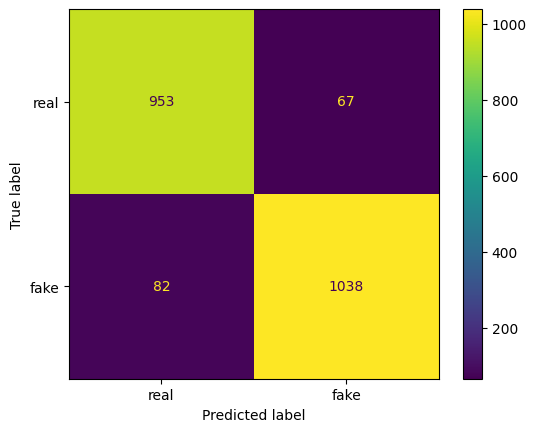

In [24]:
cm = confusion_matrix(validation_y, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['real', 'fake'])
disp.plot()
plt.show()

In [25]:
print(classification_report(validation_y, pred_y, target_names=['real','fake']))

              precision    recall  f1-score   support

        real       0.92      0.93      0.93      1020
        fake       0.94      0.93      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



In [26]:
model = LinearSVC()
model.fit(train_x_vector_counted, train_y)

pred_y = model.predict(validation_x_vector_counted)

print('Results for the basic SVM classifier:')
print(f'accuracy: {accuracy_score(pred_y, validation_y)}')
print(classification_report(validation_y, pred_y, target_names=['real','fake']))

Results for the basic SVM classifier:
accuracy: 0.9233644859813084
              precision    recall  f1-score   support

        real       0.91      0.93      0.92      1020
        fake       0.93      0.92      0.93      1120

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140



In [27]:
model = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, max_iter=5, tol=None).fit(train_x_vector_counted, train_y)
pred_y = model.predict(validation_x_vector_counted)

print('Results for the basic SGD classifier:')
print(f'accuracy: {accuracy_score(pred_y, validation_y)}')
print(classification_report(validation_y, pred_y, target_names=['real','fake']))

Results for the basic SGD classifier:
accuracy: 0.9299065420560748
              precision    recall  f1-score   support

        real       0.93      0.92      0.93      1020
        fake       0.93      0.94      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



In [28]:
model = LogisticRegression(penalty='l1',solver='saga',max_iter=4000).fit(train_x_vector_counted, train_y)
pred_y = model.predict(validation_x_vector_counted)

print('Results for L1-regularized Logistic Regression classifier:')
print(f'Accuracy: {accuracy_score(pred_y, validation_y)}')
print(classification_report(validation_y, pred_y, target_names=['real','fake']))

Results for L1-regularized Logistic Regression classifier:
Accuracy: 0.9261682242990654
              precision    recall  f1-score   support

        real       0.93      0.92      0.92      1020
        fake       0.93      0.93      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



In [29]:
model = LogisticRegression(penalty='l2',solver='saga',max_iter=4000).fit(train_x_vector_counted, train_y)
pred_y = model.predict(validation_x_vector_counted)

print('Results for L2-regularized Logistic Regression classifier:')
print(f'Accuracy: {accuracy_score(pred_y, validation_y)}')
print(classification_report(validation_y, pred_y, target_names=['real','fake']))


Results for L2-regularized Logistic Regression classifier:
Accuracy: 0.9280373831775701
              precision    recall  f1-score   support

        real       0.93      0.92      0.92      1020
        fake       0.93      0.93      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



In [30]:
model = MultinomialNB()
model.fit(train_x_vector_counted, train_y)

pred_y = model.predict(validation_x_vector_counted)

print('Results for Naive Bayes classifier:')
print(f'Accuracy: {accuracy_score(pred_y, validation_y)}')
print(classification_report(validation_y, pred_y, target_names=['real','fake']))


Results for Naive Bayes classifier:
Accuracy: 0.8995327102803738
              precision    recall  f1-score   support

        real       0.87      0.93      0.90      1020
        fake       0.93      0.87      0.90      1120

    accuracy                           0.90      2140
   macro avg       0.90      0.90      0.90      2140
weighted avg       0.90      0.90      0.90      2140



In [31]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(train_x_vector_tfIdf, train_y)

# Make predictions
y_pred = rf_classifier.predict(validation_x_vector_tfIdf)

# Calculate accuracy and classification report
accuracy = accuracy_score(validation_y, y_pred)
classification_rep = classification_report(validation_y, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_rep)

Accuracy: 0.93

Classification Report:
               precision    recall  f1-score   support

       False       0.92      0.92      0.92      1020
        True       0.93      0.93      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.92      0.93      2140
weighted avg       0.93      0.93      0.93      2140



In [32]:
bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(train_x_vector_tfIdf,train_y)
# make predictions
pred_y = bst.predict(validation_x_vector_tfIdf)

print('Results for L1-regularized Logistic Regression classifier:')
print(f'Accuracy: {accuracy_score(pred_y, validation_y)}')
print(classification_report(validation_y, pred_y))


Results for L1-regularized Logistic Regression classifier:
Accuracy: 0.8042056074766355
              precision    recall  f1-score   support

       False       0.85      0.72      0.78      1020
        True       0.78      0.88      0.82      1120

    accuracy                           0.80      2140
   macro avg       0.81      0.80      0.80      2140
weighted avg       0.81      0.80      0.80      2140



# Hyper Pramiter Tuning

In [33]:
# Define hyperparameter grid
param_grid = {
    'alpha': [0.0001, 0.001, 0.01],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'loss': ['log_loss', 'hinge'],
    'max_iter': [1000, 2000],
    'tol': [1e-3, 1e-4],
    'l1_ratio': [0.15, 0.5, 0.85]  # Only used with penalty='elasticnet'
}

# Initialize base model
model = SGDClassifier(random_state=42)

# Set up grid search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)


# Fit on training data
grid_search.fit(train_x_vector_counted, train_y)

# Evaluate on validation set
best_model = grid_search.best_estimator_
pred_y = best_model.predict(validation_x_vector_counted)

print('\nResults after grid search:')
print(f'Best parameters: {grid_search.best_params_}')
print(f'Accuracy: {accuracy_score(validation_y, pred_y)}')
print(classification_report(validation_y, pred_y, target_names=['real', 'fake']))

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Results after grid search:
Best parameters: {'alpha': 0.001, 'l1_ratio': 0.15, 'loss': 'hinge', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.001}
Accuracy: 0.9285046728971963
              precision    recall  f1-score   support

        real       0.92      0.94      0.93      1020
        fake       0.94      0.92      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140



In [36]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.05],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

model=XGBClassifier(objective='binary:logistic', random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2
)



grid_search.fit(train_x_vector_tfIdf, train_y)


#get the best model and look at the performance
best_model = grid_search.best_estimator_

finalModel=best_model.fit(train_x_vector_tfIdf, train_y)
pred_y = finalModel.predict(validation_x_vector_tfIdf)


print('\nRisultati dopo grid search:')
print(f'Parametri ottimali: {grid_search.best_params_}')
print(f'Accuracy: {accuracy_score(validation_y, pred_y)}')
print(classification_report(validation_y, pred_y, target_names=['fake', 'real']))

Fitting 3 folds for each of 32 candidates, totalling 96 fits

Risultati dopo grid search:
Parametri ottimali: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Accuracy: 0.922429906542056
              precision    recall  f1-score   support

        fake       0.93      0.91      0.92      1020
        real       0.92      0.94      0.93      1120

    accuracy                           0.92      2140
   macro avg       0.92      0.92      0.92      2140
weighted avg       0.92      0.92      0.92      2140



In [35]:
param_grid = {

    'n_estimators': [100, 200,300],
    'max_depth': [ None, 10, 30, 50, 150],
    'min_samples_split': [2, 5,10],
    'bootstrap': [True, False]
}

model= RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=3,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(train_x_vector_tfIdf, train_y)


best_model = grid_search.best_estimator_

#get the best model and look at the performance
finalModel=best_model.fit(train_x_vector_tfIdf, train_y)
y_pred = finalModel.predict(validation_x_vector_tfIdf)

# Risultati
print(f"Accuracy ottimale: {accuracy_score(validation_y, y_pred):.2f}")
print("\nClassification Report:\n", classification_report(validation_y, y_pred))
print("\nMigliori parametri:", grid_search.best_params_)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
Accuracy ottimale: 0.93

Classification Report:
               precision    recall  f1-score   support

       False       0.94      0.91      0.92      1020
        True       0.92      0.94      0.93      1120

    accuracy                           0.93      2140
   macro avg       0.93      0.93      0.93      2140
weighted avg       0.93      0.93      0.93      2140


Migliori parametri: {'bootstrap': False, 'max_depth': 150, 'min_samples_split': 10, 'n_estimators': 200}
